<a href="https://colab.research.google.com/github/AfraAd/CSC413-Homeworks/blob/main/Fall25_HW3_Autodiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 3: Autodiff

This week, you will be a set of functions to perform automatic differentiation (autodiff) and train a multi-layer perceptron using that framework. The assignment has three key tasks:

1. Complete the "Operation" class, which runs forward and backward pass for input vectors (Section 1.a, Section 2.a).
2. Complete the "Node" class, which forms a logical computation unit in a computation graph (Section 1.b).
3. Train an MLP built using your autodiff framework (Section 2).

Autodiff is the foundation of how modern neural networks are trained. This assignemnet gives you a taste of how it operates under the hood. Let's build it step-by-step!

**Some helpful links** (if you want to familiarize yourself with frameworks implementing autodiff)

* https://www.cs.toronto.edu/~rgrosse/courses/csc421_2019/readings/L06%20Automatic%20Differentiation.pdf
* https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
* https://videolectures.net/videos/deeplearning2017_johnson_automatic_differentiation

**! Do not change the following code**

In [144]:
import random
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_moons
# import networkx as nx
from graphviz import Digraph
import matplotlib.pyplot as plt

# Part 1: Autodiff from scratch (4 points)

## 1.a.Build arithmetic operation classes (2 points)
First, we will define a class of functions that compute vector operations and gradients with respect to their inputs. The child classes of Operation -- Add(), Mul(), ReLU(), MatMul() -- implements two key methods:
* **forward()**: performs arithmetic operation on the input vectors.
* **_backward()**: computes the gradients with respect to the input vectors.

The parent Operation class calls **unbroacast()** function during the backward pass. This is necessary because NumPy sometimes "broadcasts" smaller arrays to make their shapes compatible with the larger arrays. For example:

```
A = np.random.randn(3,4)
B = np.random.randn(3,1)
O = A + B  # produces an array of shape (3,4)
```

Here, $B$ is implicitly expanded across 4 columns to match the shape of $A$. When computing the gradient of $O$ with respect of $A$ and $B$, the shapes must match the original inputs:

$$\frac{\partial O}{\partial A} \in R^{3 \times 4}, \frac{\partial O}{\partial B} \in R^{3 \times 1}$$

In case of addition, both gradients are equal to the upstream gradient $\frac{\partial O}{\partial O}$, which has shape 3 x 4. To make the gradient for $B$ match its orginal shape, we must sum across the broadcasted dimension (the 4 columns). The **unbroadcast()** function handles this adjustment; it sums and reshapes gradients to undo broadcasting from the forward pass.

In [145]:
################## DO NOT CHANGE ################
def unbroadcast(grad, target):

    while grad.ndim > target.ndim:
        grad = grad.sum(axis=0)
    for axis, size in enumerate(target.shape):
        if size == 1:
            grad = grad.sum(axis=axis, keepdims=True)
    return grad

class Operation:
    def forward(self, *inputs):
        raise NotImplementedError("Needs to be implemented in the child class")

    def backward(self, grad_upstream, *inputs):
        grad = []
        grad_out = self._backward(grad_upstream, *inputs)
        for idx, g in enumerate(grad_out):
            grad.append(unbroadcast(g, inputs[idx]))
        return grad

#################################################

In [146]:
class Add(Operation):

    def __repr__(self):
        return "+"

    def forward(self, x: np.ndarray, y: np.ndarray):
        ######################### YOUR CODE #########################
        ### TODO: Return the result of the operation’s forward pass
        return x + y
        #############################################################

    def _backward(self, grad_upstream: np.ndarray, x: np.ndarray, y: np.ndarray):
        ######################### YOUR CODE #########################
        ### TODO: Return the gradients w.r.t. x, y
        #   HINT: right now, these values are initialized randomly with random size
        return [grad_upstream, grad_upstream]
        #############################################################

class Mul(Operation):

    def __repr__(self):
        return "*"

    def forward(self, x: np.ndarray, y: np.ndarray):
        ######################### YOUR CODE #########################
        ### TODO: Return the result of the operation’s forward pass
        return x*y
        #############################################################

    def _backward(self, grad_upstream: np.ndarray, x: np.ndarray, y: np.ndarray):
        ######################### YOUR CODE #########################
        ### TODO: Return the gradients w.r.t. x, y
        return [y, x]
        #############################################################

class ReLU(Operation):

    def __repr__(self):
        return "ReLU"

    def forward(self, x: np.ndarray):
        ######################### YOUR CODE #########################
        ### TODO: Return the result of the operation’s forward pass
        return np.maximum(x, 0)
        #############################################################

    def _backward(self, grad_upstream: np.ndarray, x: np.ndarray):
        ######################### YOUR CODE #########################
        ### TODO: Return the gradients w.r.t. x
        relu_grad = (x > 0).astype(x.dtype)
        return grad_upstream * relu_grad
        #############################################################

class MatMul(Operation):

    def __repr__(self):
        return "@"

    def forward(self, x: np.ndarray, y: np.ndarray):
        ######################### YOUR CODE #########################
        ### TODO: Return the result of the operation’s forward pass
        return x @ y
        #############################################################

    def _backward(self, grad_upstream: np.ndarray, x: np.ndarray, y: np.ndarray):

        ######################### YOUR CODE #########################
        ### TODO: Return the gradients w.r.t. x, y
        return [grad_upstream @ y.T, x.T @ grad_upstream]
        #############################################################

You can run the sanity check for your code by doing the following:

**Forward**
```
x = np.array(...?) # your input value x
y = np.array(...?) # your input value y
op = Add()         # or any other operation you want to test
out = op.forward(x, y)
print(np.allclose(out, expected_value))
```

**Backward**
```
grad_upstream = np.ones(...?) # what should the shape of the upstream gradient be?
grad1, grad2 = op.backward(grad_upstream, x, y)
print(np.allclose(grad1, expected_value1))
print(np.allclose(grad2, expected_value2))
```

## 1.b Node class (2 points)

With the Operation class set up, the next step is to complete the Node class. At a high-level, the Node class works as follows:

* A **Node** represents a logical unit of computation in the computation graph.
* Every Node stores a value (array).
* An input Node (or value Node) only stores its value. Any other Node produced as a result of Operation stores the 1. Operation used to create the Node and 2. the reference to its parent Nodes (inputs to the Operation).
* Except for the input Node, the value of a Node is computed only when **forward()** method is called (see Note #1 below).
* The **backward()** method applies the chain rule to propagate and accumulate gradients for each Node (self.grad).
* **topo_sort()** traverses the set of Nodes and sorts them in topological order. This ordering is necessary for both forward() and backward() functions to process the Nodes in a correct sequence.

**NOTE**

1. The apporach that delays the computation of the forward values is called *lazy evaluation*, which was used in frameworks like Theano and Tensorflow 1.x. In contrast, modern PyTorch and Tensorflow 2.x implement *eager execution*, which computes the values immediately as they are created. Lazy evaluation can still be beneficial, as it allows for global graph-level optimizations.
2. You can visualize the computation graph formed by the Nodes using visualize_computation_graph() function provided below.

In [147]:
def topo_sort(node):
    ######################### YOUR CODE #########################
    # TODO: Use a graph traversal algorithm to generate a topological
    #       ordering of the nodes, following the dependencies in the
    #       computation graph.
    topo_order = []
    visited = set()

    def _visit(n):
        if n is None:
            return
        nid = id(n)
        if nid in visited:
            return
        visited.add(nid)
        for p in getattr(n, "parents", ()):
            _visit(p)
        topo_order.append(n)

    _visit(node)
    return topo_order
    ##############################################################

class Node:
    def __init__(self, name=None, value=None):
        self.name = name
        self.value = np.array(value)
        self.op = None
        self.parents = []
        self.grad = 0

    def __repr__(self):
        return f"(value {self.value}, op {self.op}, parents {self.parents})"

    def forward(self):

        # Perform topological sort of the nodes
        topo_order = topo_sort(self)
        # Iterate through the sorted nodes to compute and store each node’s forward value.
        for node in topo_order:
            if node.op is not None:
                #################### YOUR CODE ####################
                # TODO: Compute the forward value of the Node in the graph
                parent_values = [p.value for p in node.parents]
                node.value = node.op.forward(*parent_values)
                ###################################################

    def backward(self):

        # Perform topological sort of the nodes
        topo_order = topo_sort(self)
        # Set the gradients w.r.t current node as 1
        self.grad = np.ones_like(self.value)

        # Iterate through the sorted nodes to compute and accumulate gradients for each node.
        for node in topo_order[::-1]:
            if node.op is not None:
                ###################### YOUR CODE ###############################
                # TODO: Perform backward pass of the current node
                #       And propagate the current node's gradient to its parents
                parent_values = [p.value for p in node.parents]
                grads = node.op._backward(self.grad, *parent_values)
                for p, g in zip(node.parents, grads):
                  if isinstance(p.grad, int):
                      p.grad = g
                  else:
                      p.grad += g
                ###############################################################

def get_node(parents, op, name=None, value=None):
    if isinstance(value, np.ndarray):
        n = Node(name=name, value=value)
    else:
        n = Node(name=name, value=[[value]])
    n = Node(name=name, value=value)
    n.parents=parents
    n.op=op
    return n

As a sanity check, you can try creating a computation graph and run forward and backward passes on them:

```
node_a = get_node(name='node_a', value=np.random.randn(2,2), parents=[], op=None)
node_b = get_node(name='node_b', value=inp.random.randn(2,2), parents=[], op=None)
node_c = get_node(name='node_c', parents=[node_a, node_b], op = Add())
final_node = get_node(name='final_node', parents=[node_c, node_a], op = Some other operation)

final_node.foward()
np.allclose(node_c.value, expected_value)
np.allclose(final_node.value, expected_value)

final_node.backward()
np.allclose(node_c.grad, expected_value)
np.allclose(final_node.grad, expected_value)

```
Also, you can check the comptuation graph formed by these Nodes using visualize_computation_graph(final_node)

In [148]:
def visualize_computation_graph(node):
    dot = Digraph(format="png", graph_attr={"rankdir": "LR"})
    visited = set()

    def add_nodes(n):
        if n in visited:
            return
        visited.add(n)

        # Add current node
        dot.node(str(id(n)), label=f"{str(n.name)}\nop: {str(n.op)}\nshape: {n.value.shape}")

        # Add edges to parents
        if hasattr(n, "parents"):
            for p in n.parents:
                dot.edge(str(id(p)), str(id(n)))
                add_nodes(p)

    add_nodes(node)
    return dot

node_c value:
 [[0.21650019]]
final_node value:
 [[-0.07923658]]
node_c grad:
 [[-0.36598851]]
node_a grad:
 [[1.21650019]]
final_node grad:
 [[1.]]


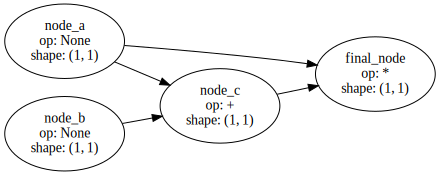

In [149]:
# -------------------------
# Build computation graph
# -------------------------
node_a = get_node(name='node_a', value=np.random.randn(1,1), parents=[], op=None)
node_b = get_node(name='node_b', value=np.random.randn(1,1), parents=[], op=None)
node_c = get_node(name='node_c', parents=[node_a, node_b], op = Add())
final_node = get_node(name='final_node', parents=[node_c, node_a], op = Mul())

# -------------------------
# Forward pass
# -------------------------
final_node.forward()
print("node_c value:\n", node_c.value)
print("final_node value:\n", final_node.value)

# -------------------------
# Backward pass
# -------------------------
final_node.backward()
print("node_c grad:\n", node_c.grad)
print("node_a grad:\n", node_a.grad)
print("final_node grad:\n", final_node.grad)

# -------------------------
# Visualize graph
# -------------------------
dot = visualize_computation_graph(final_node)
display(dot)

# Part 2: Build MLP with autodiff (2.5 points)

Now you will use the autodiff framework you built to train an MLP model. In week 2, you trained an MLP by explicitly applying the derived partial derivatives. This time, you will rely on your autodiff framework to automatically compute and propagate the gradients through the network!

For initializing the weights and biases of the layer, use the same initialization that has been provided to you in week 2 homework.

## 2.a Build a basic MLP model (0.5 point)

In [150]:
class Layer:
    def __init__(self, input_dim, output_dim):
        ############### YOUR CODE ################
        # TODO: use the Node() class to produce
        #       weights and biases of the layer
        #       Implement the same initialization that has been used
        #       from week 2 homework.
        w_val = np.random.randn(output_dim, input_dim) * np.sqrt(2.0 / input_dim)
        b_val = np.zeros((output_dim, 1))
        self.weights = get_node(parents=[], op=None, name="weights", value=w_val)
        self.biases  = get_node(parents=[], op=None, name="biases",  value=b_val)
        ###########################################

    def __call__(self, X: Node) -> Node:
        ############### YOUR CODE ################
        ## TODO: Use get_node() to compute (Wx + b)
        #        then apply ReLU to the output
        out = get_node(name='out', value=self.weights.value @ X.value + self.biases.value, parents=[X], op=ReLU())
        out.forward()
        return out
        ###########################################

    def parameters(self):
        return [self.weights, self.biases]

In [151]:
class LinearMLP:
    def __init__(self, layer_widths):
        self.layers = []
        ############### YOUR CODE ################
        ## TODO: Create the layers of MLP
        ##########################################
        self.layers = [Layer(input_dim, output_dim) for input_dim, output_dim in zip(layer_widths[:-1], layer_widths[1:])]

    def __call__(self, inputs: Node) -> Node:
        a = inputs
        ############### YOUR CODE ################
        ## TODO: Implement forward pass of the MLP
        return self.layers[0](a)
        ##########################################


    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def zero_grad(self):
        ################## YOUR CODE ####################
        # TODO: Set gradients of all the nodes to zero
        #       This function is called during training
        #       to empty accumulated gradients
        for p in self.parameters():
            p.grad = np.zeros_like(p.grad)
        #################################################

You can test your Layer code by building a simple layer to begin with:

```
layer = Layer(dim1, dim2)
x_input = get_node(value=np.random.randn(dim, dim), parents=[], op=None)
out_node = layer(x_input)
out_node.forward()
print(np.allclose(out_node.value, expected_value))
```

Similarly, for MLP code, you can build a mini model:

```
model = LinearMLP([2, 4, 2]) # 2 layer MLP, input dim=2, output dim=2
x_input = get_node(value=np.random.randn(2,4), parents=[], op=None)
out = model(x_input)
out.forward()
out.backward()

print(np.allclose(model.parameters()[0].grad, expected_value))
print(np.allclose(model.parameters()[1].grad, expected_value))

```

In [152]:
layer = Layer(2, 3)
x_input = get_node(value=np.random.randn(2, 1), parents=[], op=None)
out_node = layer(x_input)
out_node.forward()
print(out_node.value)

model = LinearMLP([2, 4, 2])
x_input = get_node(value=np.random.randn(2,4), parents=[], op=None)
out = model(x_input)
out.forward()
out.backward()

print(model.parameters()[0].grad)
print(model.parameters()[1].grad)

[[0.]
 [0.]]
0
0


## 2.b Implement Softmax, cross-entropy loss operations (1 point)

Before training an MLP, we need to implement additional operations for softmax and cross-entropy loss. There are two possible approaches:
* Implement Softmax() and CrossEntropyLoss() separately, then call them in order during training.
* Implement SoftmaxCrossEntropyLoss() as a single Operation, which combines both steps and simplifies the gradient computation.

Softmax and CrossEntropyLoss operations are atomic, but in practice, many deep learning grameworks combine them as a single operation (second version) for efficiency and numerical stability. Here, you will implement both versions to see they produce the same output. You can do the math to derive separate backpropagations for each approach, and see that they return the same values.

In [173]:
class Softmax(Operation):
    def __repr__(self):
        return "Softmax"

    def forward(self, x: np.ndarray):
        exp = np.exp(x - np.max(x, axis=0, keepdims=True))
        res = exp / np.sum(exp, axis=0, keepdims=True)
        return res

    def _backward(self, grad_upstream: np.ndarray, x: np.ndarray):
        ############### YOUR CODE ###########################
        ### TODO: Return the gradients w.r.t. x
        s = self.forward(x).reshape(-1, 1)
        # Jacobian: s * I - s @ s.T
        jacobian = np.diagflat(s) - np.dot(s, s.T)
        grad_x = np.dot(jacobian, grad_upstream)
        return [grad_x]
        #####################################################

class CrossEntropyLoss(Operation):
    def __repr__(self):
        return "CrossEntropyLoss"

    def forward(self, pred: np.ndarray, target: np.ndarray):
        loss = -np.sum(target * np.log(pred + 1e-8)) / target.shape[1]
        return loss

    def _backward(self, grad_upstream: np.ndarray, pred: np.ndarray, target: np.ndarray):
        ############### YOUR CODE ###########################
        ### TODO: Return the gradients w.r.t. pred, target
        sol1 = grad_upstream * (-target / (pred + 1e-8)) / target.shape[1]
        sol2 = grad_upstream * (-np.log(pred + 1e-8)) / target.shape[1]
        return [sol1, sol2]
        #####################################################

class SoftmaxCrossEntropyLoss(Operation):
    def __repr__(self):
        return "Softmax+CE"

    def forward(self, logit: np.ndarray, target: np.ndarray):
        ############### YOUR CODE ###########################
        # TODO: Implement softmax, and then cross entropy loss
        #       Return the cross entropy loss of the logit and target
        softmax = Softmax().forward(logit)
        ce_loss = CrossEntropyLoss().forward(softmax, target)
        return ce_loss
        #####################################################

    def _backward(self, grad_upstream: np.ndarray, logit: np.ndarray, target: np.ndarray):
        ############### YOUR CODE ###########################
        ### TODO: Return the gradients w.r.t. logit, target
        sol1 = Softmax()._backward(grad_upstream, logit)[0]
        sol2 = CrossEntropyLoss()._backward(grad_upstream, logit, target)[0]
        return [sol1, sol2]
        #####################################################

When you implement them correctly, you should see that the two approaches return the same forward and backward values:

```
logit1 = Node(value=some_fixed_value)
target1 = Node(value=some_target_value)
softmax_logit = get_node(parents=[logit1], op=Softmax())
final_loss1 =  get_node(parents=[softmax_logit, target1], op=CrossEntropyLoss())
final_loss1.forward()
final_loss1.backward()
print(np.allclose(logit1.grad, expected_value))
```

```
logit2 = Node(value=same_value_as_logit1)
target2 = Node(value=same_value_as_target1)
final_loss2 = get_node(parents=[logit2, target2], op=SoftmaxCrossEntropyLoss())
final_loss2.forward()
final_loss2.backward()
print(np.allclose(final_loss2.value, final_loss1.value))
print(np.allclose(logit2.grad, logit1.grad))
```

1.0


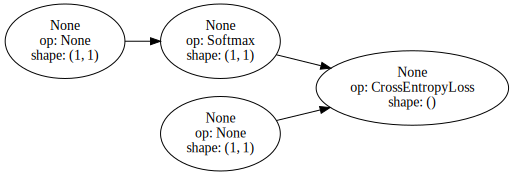

In [176]:
logit1 = get_node(value=np.array([[2]]), parents=[], op=None)
target1 = get_node(value=np.array([[3]]), parents=[], op=None)

softmax_logit = get_node(parents=[logit1], op=Softmax())
final_loss1 = get_node(parents=[softmax_logit, target1], op=CrossEntropyLoss())

final_loss1.forward()
final_loss1.backward()

print(final_loss1.grad)
dot = visualize_computation_graph(final_loss1)
display(dot)

## 2.c Train the MLP (1 point)

Finally, we can train the autodiff-based MLP model! Complete the step_network() function below. As you train, check whether your model can reach 90%+ accuracy within 500 steps (it should given the random seed provided, if every operation is implemented correctly). Once the training is complete, you can visualize the convergence by running the visualize_convergence() function below.

In [155]:
#################### DO NOT MODIFY ####################

def visualize_convergence(model, X, y):

    h = 0.25
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]

    model_inputs = Node(value=Xmesh.T)
    out = model(model_inputs)
    out.forward()
    pred = np.argmax(out.value, axis=0)

    Z = np.where(pred > 0, 1, -1).astype(int)
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    plt.contourf(xx, yy, Z, levels=[-1,0,2],alpha=0.8, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.coolwarm)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

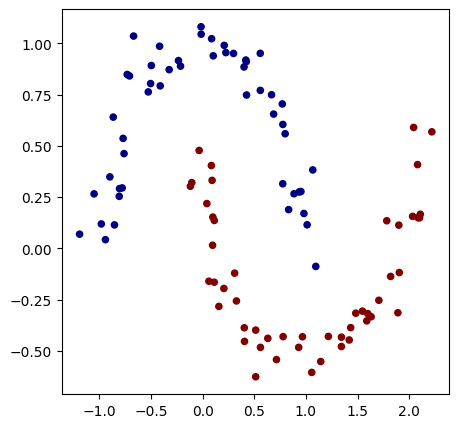

In [177]:
#################### DO NOT MODIFY ####################
X, y = make_moons(n_samples=100, noise=0.1)
y = y*2 - 1 # make y be -1 or 1
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [178]:
#################### DO NOT MODIFY ####################
model = LinearMLP([2, 16, 2]) # 2 layer MLP
X_node = get_node(name='X', value=X.T, op=None, parents=[])
y_onehot = OneHotEncoder().fit_transform(y.reshape(-1,1)).toarray()
y_node = get_node(name='y', value=y_onehot.T, op=None, parents=[])

# Before training
layer_output = model(X_node)
loss = get_node(name='loss', op=SoftmaxCrossEntropyLoss(), parents=[layer_output, y_node])
loss.forward()
loss.backward()

print(loss.value)

1.1017785846219592


In [179]:
def step_network(network, inputs, targets, learning_rate):

    #################### YOUR CODE ############################
    # TODO: Complete the training code using the Node() class,
    #       and operations (if needed) we built earlier.
    #       This function should return the loss from that step.
    #       Hint: refer to the week2 homework code to implement
    #             a new version of the step_network using the Node
    #             and Operations we built
    network.zero_grad()
    out = network(inputs)
    loss = get_node(name='loss', op=SoftmaxCrossEntropyLoss(), parents=[out, targets])
    loss.forward()
    loss.backward()
    return loss.value
    ##########################################################

def train_linear_mlp(mlp, learning_rate, n_iterations, inputs, targets):
    losses = []
    acc = []
    for _ in range(n_iterations):
        loss = step_network(mlp, inputs, targets, learning_rate)
        losses.append(loss)

    return losses

Accuracy:  0.21


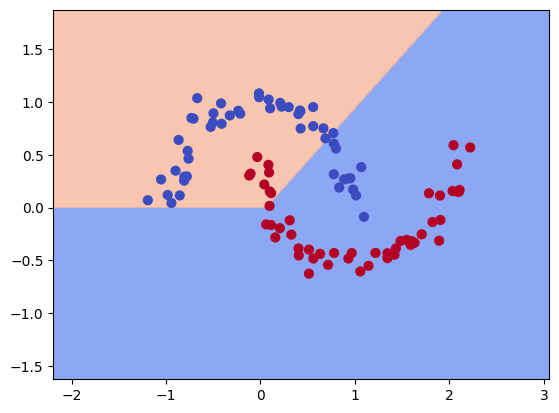

In [180]:
############### SANITY CHECK ###############
SEED = 123
np.random.seed(SEED)

model = LinearMLP([2, 16, 2]) # one layer MLP, input_dim=2, hidden_dim=16, output_dim=2
X_node = get_node(name='X', value=X.T, op=None, parents=[])
y_onehot = OneHotEncoder().fit_transform(y.reshape(-1,1)).toarray()
y_node = get_node(name='y', value=y_onehot.T, op=None, parents=[])
losses = train_linear_mlp(model, 0.2, 500, X_node, y_node)

# accuracy on the train set
out = model(X_node)
out.forward()

print("Accuracy: ", (np.argmax(out.value, axis=0) == ((y > 0) * 1)).mean())
visualize_convergence(model, X, y)